# simulation experiment
The composition schema was developed for integrative simulations, but can also be used for workflows such as simulation experiments.

In [1]:
from bigraph_viz import plot_bigraph, plot_flow, pf

plot_settings = {
    'remove_process_place_edges': True,
}
save_images = False
if save_images:
    plot_settings.update({'out_dir': 'out', 'dpi': '250'})

## simulation experiment design with bigraph-schema

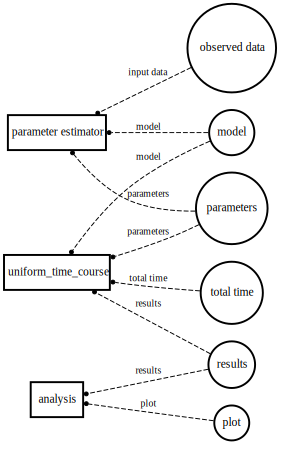

In [2]:
simulation_experiment_spec = {
    # '_type': 'sbml_simulation_experiment',
    'parameter estimator': {
        '_type': 'process:step',
        '_ports': {
            'input data': 'Any', 
            'model': 'SBML', 
            'parameters': 'Any',
        },
        'wires': {
            'input data': 'observed data',
            'model': 'model',
            'parameters': 'parameters',
        },
        '_depends_on': []
    },
    'uniform_time_course': {
        '_ports': {
            'model': 'SBML', 
            'parameters': 'Any',
            'total time': 'time',
            'results': 'Any'
        },
        'wires': {
            'parameters': 'parameters',
            'model': 'model',
            'total time': 'total time',
            'results': 'results',
        },
        '_depends_on': ['parameter estimator'],
    },
    'analysis': {
        '_ports': {
            'results': 'Any',
            'plot': 'Any',
        },
        'wires': {
            'results': 'results',
            'plot': 'plot',
        },
        '_depends_on': ['uniform_time_course'],
    },
    'parameters': 'Any',
    'model': 'Any',
    'results': 'Any',
    'observed data': 'Any',
    'total time': 'Any',
}

plot_bigraph(simulation_experiment_spec, **plot_settings, rankdir='RL', filename='simulation_experiment')

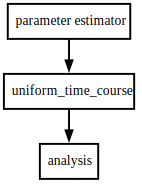

In [3]:
plot_flow(simulation_experiment_spec)

## Functions for Lucian's requested examples.
https://docs.google.com/document/d/1jZkaNhM_cOqMWtd4sJZ9b0VGXPTLsDKsRNI5Yvu4nOA/edit

https://sed-ml.org/urns.html

### imports

In [4]:
import inspect
import itertools
from typing import Callable, Any, List, Dict, Union, Optional, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import tellurium as te
import pandas as pd
import json

### functions for handling ports, annotations, registration

In [5]:
# decorators for annotation and ports
def annotate(annotation):
    def decorator(func):
        func.annotation = annotation
        return func
    return decorator


def ports(ports_schema):
    # assert inputs/outputs and types, give suggestions
    allowable = ['inputs', 'outputs']
    assert all(key in  allowable for key in ports_schema.keys()), f'{[key for key in ports_schema.keys() if key not in allowable]} not allowed as top-level port keys. Allowable keys include {str(allowable)}'
    # TODO assert type are in type_registry
    # TODO check that keys match function signature
    def decorator(func):
        func.ports = ports_schema
        return func
    return decorator


# serialization of scripts
def serialize_instance(
    wiring: Dict
) -> str:
    return json.dumps(wiring)


def generate_script(
    json_str: str, 
    process_registry: Dict[str, Callable]
) -> str:
    """Generate an executable Python script from the declarative JSON format"""
    deserialized_wiring = json.loads(json_str)
    script = []
    a = [v.get('annotation') for k, v in process_registry.items()]
    for name, value in deserialized_wiring.items():
        if isinstance(value, dict) and (value.get('_type' ) in a):
            if name in process_registry:
                ports = process_registry[name]['ports']
                wires = value['wires']
                func_script = None
                inputs = ports.get('inputs')
                outputs = ports.get('outputs')
                if inputs:
                    input_values = [(key, wires[key]) for key in inputs.keys()]
                    input_args = ", ".join(f'{arg}={val}' for (arg, val) in input_values)
                    func_script = f"{name}({input_args})"
                else:
                    func_script = f"{name}()"
                if outputs:
                    output_values = [(key, wires[key]) for key in outputs.keys()]
                    output_args = ", ".join(f'{val}' for (arg, val) in output_values)
                    func_script = f"{output_args} = " + func_script
                script.append(func_script)
            else:
                Exception(f"Function '{name}' not found in the process registry.")
        elif isinstance(value, dict) and value.get('wires'):
            Exception(f"Function '{name}' not found in the process registry.")
        else:
            script.insert(0, f'{name} = {value}')
    return "\n".join(script)


# registration
class ProcessRegistry(dict):
    def get_annotations(self):
        annotations = []
        for k, v in self.__dict__.items():
            a = getattr(v, "annotation", None)
            if a:
                annotations.append(a)
        return annotations
    

def register(functions, process_registry=None):
    if not process_registry:
        process_registry = ProcessRegistry()
    for func in functions:
        process_registry[func.__name__] = {
            # "signature": str(inspect.signature(func)),
            "annotation": getattr(func, "annotation", None),
            "ports": getattr(func, "ports", None),
            "process": func
        }
    return process_registry

### SED processes

These are the processes that are required for SED execution

In [48]:
class Model:
    def __init__(
        self, 
        sedml_language: str, 
        sbml_file: str
    ):
        self.sedml_language = sedml_language
        self.sbml_file = sbml_file
        self.sbml_model = te.loadSBMLModel(self.sbml_file)

    def set(
        self, 
        element_id: str, 
        value: float
    ):
        if element_id in self.sbml_model.getFloatingSpeciesIds():
            self.sbml_model.setValue(element_id, value)
        elif element_id in self.sbml_model.getGlobalParameterIds():
            self.sbml_model.setValue(element_id, value)
        else:
            raise Exception(f'species {element_id} does not exist') 

    def reset(self):
        self.sbml_model.reset()
    
    def get_value(self, element_id: str) -> float:
        return self.sbml_model.getValue(element_id)

@ports({'inputs': {
            'path_to_sbml': 'str'}, 
        'outputs': {
            'model': 'Model'}})
@annotate("sed:sbml_model_from_path")
def sbml_model_from_path(path_to_sbml):
    return Model("urn:sedml:language:sbml", path_to_sbml)
    

@ports({'inputs': {'model_instance': 'Model'}})
@annotate("sed:model_reset")
def model_reset(model_instance):
    """Reset the model instance to its initial state."""
    model_instance.reset()

    
@ports({
    'inputs': {
        'model_instance': 'Model',
        'element_id': 'str',
        'value': 'float'}})
@annotate("sed:set_model")
def set_model(model_instance: Model, element_id, value):
    """Set a new value for a species or parameter in the model instance."""
    model_instance.set(element_id, value)


@ports({
    'inputs': {
        'model': 'Model',
        'time_start': 'float', 
        'time_end': 'float', 
        'num_points': 'int', 
        'selection_list': 'List[str]'},
    'outputs': {
        'results': 'dict'}})
@annotate("sed:uniform_time_course")
def uniform_time_course(
    model, 
    time_start, 
    time_end, 
    num_points, 
    selection_list=None
):
    """Run a uniform time course simulation on the model."""
    sim_result = model.sbml_model.simulate(start=time_start, end=time_end, points=num_points, selections=selection_list)
    return {column: sim_result[column] for column in sim_result.colnames}



@ports({
'inputs': {
    'data_file': 'str',
    'file_format': 'str'},
'outputs': {
    'data': 'pd.DataFrame'}})
@annotate("sed:data_description")
def data_description(data_file: str, file_format: str):
    """Load data from a file in the specified format."""
    if file_format == "CSV":
        data = pd.read_csv(data_file)
    return data


@ports({
    'inputs': {
        'sim': 'Dict[str, np.ndarray]',
        'data': 'pd.DataFrame'},
    'outputs': {
        'sum': 'float'}})
@annotate("sed:sum_of_squares")
def sum_of_squares(sim, data):
    """Calculate the sum of squared differences between simulation and data."""
    sim_df = pd.DataFrame(sim)
    diff = sim_df.set_index('time') - data.set_index('time')
    return np.sum(diff**2).sum()


class curve:
    def __init__(
        self, 
        x_values: np.ndarray, 
        y_values: np.ndarray, 
        name: Optional[str] = None
    ):
        self.x_values = x_values
        self.y_values = y_values
        self.name = name


@ports({
    'inputs': {
        'name': 'str',
        'curves': 'dict'}})
@annotate("sed:plot2d")
def plot2d(
    name: str, 
    curves: dict
) -> None:
    """Create a 2D plot of the given curves."""
    plt.figure(name)
    for curve_name, pos in curves.items():
        curve_obj = curve(pos['x'], pos['y'], name=curve_name)
        plt.plot(curve_obj.x_values, curve_obj.y_values, label=curve_obj.name)
    plt.legend()
    plt.show()


@annotate("sed:steady_state")
def steady_state(
    model: Model, 
    selection_list: Optional[List[str]] = None
) -> Dict[str, float]:
    """Calculate the steady state values of the model."""
    sbml_model = te.loadSBMLModel(model.sbml_file)
    steady_state_values = sbml_model.getSteadyStateValues()
    ids = sbml_model.getFloatingSpeciesIds() + sbml_model.getGlobalParameterIds()
    result_dict = {}
    for i, id in enumerate(ids):
        if id in selection_list:
            result_dict[id] = steady_state_values[i]
    return result_dict


def report_dict(result: Dict[str, Union[float, np.ndarray]]):
    for key, value in result.items():
        print(f"{key}: {value}")


@ports({
    'inputs': {
        'results': 'Union[List[Dict[str, Union[float, np.ndarray]]]]',
        'title': 'str'}})        
@annotate("sed:report")
def report(results, title = None
):
    """Print the results."""
    if title:
        print(title)
    if isinstance(results, list):
        for result in results:
            report_dict(result)
    if isinstance(results, dict):
        report_dict(results)


@ports({
    'inputs': {
        'input_dict': 'dict',
        'model': 'Model', 
        'data_description': 'pd.DataFrame',
        'time_start': 'float', 
        'time_end': 'float', 
        'num_points': 'int'},
    'outputs': {
        'results': 'dict'}})
@annotate("sed:n_dimensional_scan")      
def n_dimensional_scan(
    input_dict, 
    model, 
    data_description,
    time_start, 
    time_end, 
    num_points,
):
    combinations = list(itertools.product(*input_dict.values()))
    keys = list(input_dict.keys())
    selection_list = keys + ["time"]
    results = {}
    for c in combinations:
        model_instance.reset()
        for idx, v in enumerate(c):
            model_instance.set(keys[idx], v)
        sim1 = uniform_time_course(
            model, time_start, time_end, num_points, selection_list=selection_list)
        results[c] = sum_of_squares(sim1, data_description)
    return results


@ports({
    'inputs': {
        'config': 'dict'},
    'outputs': {
        'results': 'list'}})
@annotate("sed:repeated_simulation")   
def repeated_simulation(config):
    results = []
    for key, values in config.items():
        for value in values:
            model_instance.reset()
            model_instance.set(key, float(value))
            sim1 = uniform_time_course(model_instance, 0, 10, 5, selection_list=["time", "S", "Z"])
            results.append(sim1)
    return results


### register the SED processes

In [49]:
# register functions
functions = [
    sbml_model_from_path,
    uniform_time_course, 
    model_reset,
    set_model,
    data_description, 
    sum_of_squares, 
    plot2d, 
    steady_state, 
    report,
    n_dimensional_scan,
    repeated_simulation,
]
        
process_registry = register(functions)
print(pf(process_registry))

{ 'data_description': { 'annotation': 'sed:data_description',
                        'ports': { 'inputs': { 'data_file': 'str',
                                               'file_format': 'str'},
                                   'outputs': {'data': 'pd.DataFrame'}},
                        'process': <function data_description at 0x2966b4430>},
  'model_reset': { 'annotation': 'sed:model_reset',
                   'ports': {'inputs': {'model_instance': 'Model'}},
                   'process': <function model_reset at 0x172e80dc0>},
  'n_dimensional_scan': { 'annotation': 'sed:n_dimensional_scan',
                          'ports': { 'inputs': { 'data_description': 'pd.DataFrame',
                                                 'input_dict': 'dict',
                                                 'model': 'Model',
                                                 'num_points': 'int',
                                                 'time_end': 'float',
                            

## Example scripts

### example 1
Run a simulation from time start to time end with a given number of points/steps.  The run will return a 2D array of results.

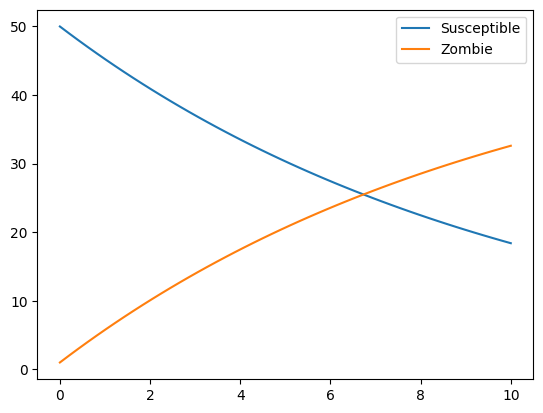

In [8]:
model_instance = Model("urn:sedml:language:sbml", "susceptible_zombie.xml")
sim1 = uniform_time_course(model_instance, 0, 10, 50, selection_list=["time", "S", "Z"])
curves = {
    'Susceptible': {'x': sim1["time"], 'y': sim1["S"]},
    'Zombie': {'x': sim1["time"], 'y': sim1["Z"]}
}
plot2d(name="Figure 3", curves=curves)

### example 2
Run a single steady-state simulation, The run returns a 1D array containing the steady state values.

In [9]:
model_instance = Model("urn:sedml:language:sbml", "susceptible_zombie.xml")
ss1 = steady_state(model_instance, selection_list=["S", "Z"])
report(ss1, title="Steady States")

Steady States
S: 1.0587911840678754e-22
Z: 51.0


### example 3
Set parameters and/or initial conditions and run time course or steady state evaluation.

In [10]:
model_instance = Model("urn:sedml:language:sbml", "susceptible_zombie.xml")
set_model(model_instance, "Z", 0.0)
ss1 = steady_state(model_instance, selection_list=["S", "Z"])
report(ss1, title="Steady States")

Steady States
S: 1.0587911840678754e-22
Z: 51.0


### example 4
Repeat simulations any number of times and with any degree of nesting.  Any changes may be applied to parameters, initial conditions etc within the repeated simulations.  The results of the simulation will be collected into arrays.

In [11]:
model_instance = Model("urn:sedml:language:sbml", "susceptible_zombie.xml")
config = {
    'Z': list(range(1, 11))
}
results = repeated_simulation(config)
report(results, title="Different starting Z values")

Different starting Z values
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94003035 30.32651341 23.61828935 18.39390318]
Z: [ 1.         12.05996965 20.67348659 27.38171065 32.60609682]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004271 30.3265222  23.61829995 18.39387556]
Z: [ 2.         13.05995729 21.6734778  28.38170005 33.60612444]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004572 30.32652512 23.6183302  18.39399716]
Z: [ 3.         14.05995428 22.67347488 29.3816698  34.60600284]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94005934 30.32656148 23.61832184 18.39393547]
Z: [ 4.         15.05994066 23.67343852 30.38167816 35.60606453]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94006923 30.32664465 23.61839919 18.39396   ]
Z: [ 5.         16.05993077 24.67335535 31.38160081 36.60604   ]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004474 30.32656757 23.61833607 18.39394121]
Z: [ 6.         17.05995526 25.67343243 32.38166393 37.6060

### example 5
Carry out an n-D parameter scan and return the results in an array.

In [12]:
model_instance = Model("urn:sedml:language:sbml", "susceptible_zombie.xml")
SZ_data = data_description("susceptible_zombie.csv", "CSV")
config = {
    'S': np.arange(0.0, 0.010, step=0.002),
    'Z': np.arange(0.0, 0.010, step=0.002)
}
results = n_dimensional_scan(
    config, 
    model=model_instance,
    data_description=SZ_data,
    time_start=0, 
    time_end=10, 
    num_points=5
)
report(results, title="Parameter scan")

Parameter scan
(0.0, 0.0): 0.0
(0.0, 0.002): 0.0
(0.0, 0.004): 0.0
(0.0, 0.006): 0.0
(0.0, 0.008): 0.0
(0.002, 0.0): 0.0
(0.002, 0.002): 0.0
(0.002, 0.004): 0.0
(0.002, 0.006): 0.0
(0.002, 0.008): 0.0
(0.004, 0.0): 0.0
(0.004, 0.002): 0.0
(0.004, 0.004): 0.0
(0.004, 0.006): 0.0
(0.004, 0.008): 0.0
(0.006, 0.0): 0.0
(0.006, 0.002): 0.0
(0.006, 0.004): 0.0
(0.006, 0.006): 0.0
(0.006, 0.008): 0.0
(0.008, 0.0): 0.0
(0.008, 0.002): 0.0
(0.008, 0.004): 0.0
(0.008, 0.006): 0.0
(0.008, 0.008): 0.0


## SED-ON to scripts

### example 1

reproduce this script:
```
model_instance = Model("urn:sedml:language:sbml", "susceptible_zombie.xml")
sim1 = uniform_time_course(model_instance, 0, 10, 50, selection_list=["time", "S", "Z"])
curves = {
    'Susceptible': {'x': sim1["time"], 'y': sim1["S"]},
    'Zombie': {'x': sim1["time"], 'y': sim1["Z"]}
}
plot2d(name="Figure 3", curves=curves)
```

In [50]:
sbml_model_from_path.ports

{'inputs': {'path_to_sbml': 'str'}, 'outputs': {'model': 'Model'}}

In [57]:
instance = {
    'time_start': 0,
    'time_end': 10,
    'num_points': 50,
    'selection_list': ['time', 'S', 'Z'],
    'UTC': '"UTC"',
    'model_path': '"susceptible_zombie.xml"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        }
    },
    'uniform_time_course': {
        '_type': 'sed:uniform_time_course',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        }
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'
        }
    }
}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str1 = serialize_instance(instance)
print(json_str1)

{"time_start": 0, "time_end": 10, "num_points": 50, "selection_list": ["time", "S", "Z"], "UTC": "\"UTC\"", "model_path": "\"susceptible_zombie.xml\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "uniform_time_course": {"_type": "sed:uniform_time_course", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}}}


In [58]:
# Generate the script
script1 = generate_script(json_str1, process_registry)
print(script1)

model_path = "susceptible_zombie.xml"
UTC = "UTC"
selection_list = ['time', 'S', 'Z']
num_points = 50
time_end = 10
time_start = 0
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = uniform_time_course(model=model_instance, time_start=time_start, time_end=time_end, num_points=num_points, selection_list=selection_list)
report(results=results, title=UTC)


In [59]:
exec(script1)

UTC
time: [ 0.          0.20408163  0.40816327  0.6122449   0.81632653  1.02040816
  1.2244898   1.42857143  1.63265306  1.83673469  2.04081633  2.24489796
  2.44897959  2.65306122  2.85714286  3.06122449  3.26530612  3.46938776
  3.67346939  3.87755102  4.08163265  4.28571429  4.48979592  4.69387755
  4.89795918  5.10204082  5.30612245  5.51020408  5.71428571  5.91836735
  6.12244898  6.32653061  6.53061224  6.73469388  6.93877551  7.14285714
  7.34693878  7.55102041  7.75510204  7.95918367  8.16326531  8.36734694
  8.57142857  8.7755102   8.97959184  9.18367347  9.3877551   9.59183673
  9.79591837 10.        ]
S: [50.         48.98993116 48.00026076 47.0305906  46.0805115  45.14962559
 44.23754479 43.34388863 42.46828486 41.61036896 40.76978345 39.94617894
 39.13921186 38.34854706 37.57385459 36.81481239 36.07110382 35.34241938
 34.62845528 33.92891399 33.24350361 32.57193948 31.91394172 31.26923494
 30.63755248 30.01863156 29.41221203 28.81804357 28.23587932 27.66547412
 27.10659238

# scripts to declarative and back

### toy processes

In [17]:
@ports({
    "inputs": {"a": "int", "b": "int"}, 
    "outputs": {"c": "int"}})
@annotate("math:add")
def add(a, b):
    return a + b

@ports({
    "inputs": {"a": "int", "b": "int"}, 
    "outputs": {"c": "int"}})
@annotate("math:multiply")
def multiply(a, b):
    return a * b

@ports({"inputs": {"a": "Any"}})
@annotate("math:print_result")
def print_result(a):
    print(a)

### register toy processes

In [18]:
# register processes
functions = [
    add, 
    multiply, 
    print_result,
]
toy_process_registry = register(functions)
print(pf(toy_process_registry))

{ 'add': { 'annotation': 'math:add',
           'ports': { 'inputs': {'a': 'int', 'b': 'int'},
                      'outputs': {'c': 'int'}},
           'process': <function add at 0x2967b1ca0>},
  'multiply': { 'annotation': 'math:multiply',
                'ports': { 'inputs': {'a': 'int', 'b': 'int'},
                           'outputs': {'c': 'int'}},
                'process': <function multiply at 0x2967b1d30>},
  'print_result': { 'annotation': 'math:print_result',
                    'ports': {'inputs': {'a': 'Any'}},
                    'process': <function print_result at 0x2967b1dc0>}}


### declarative json string

In [19]:
# Example function calls with input and output arguments
instance = {
    'add': {
        '_type': 'math:add',
        'wires': {
            'a': 'a', 
            'b': 'b', 
            'c': 'sum_result',
        }
    },
    'multiply': {
        '_type': 'math:multiply',
        'wires': {
            'a': 'sum_result', 
            'b': 'd',
            'c': 'product_result',
        }
    },
    'print_result': {
        '_type': 'math:print_result',
        'wires': {
            'a': 'product_result', 
        },
        '_depends_on': [],
    },
    'a': 2,
    'b': 3,
    'd': 5,
}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str = serialize_instance(instance)
print(json_str)

{"add": {"_type": "math:add", "wires": {"a": "a", "b": "b", "c": "sum_result"}}, "multiply": {"_type": "math:multiply", "wires": {"a": "sum_result", "b": "d", "c": "product_result"}}, "print_result": {"_type": "math:print_result", "wires": {"a": "product_result"}, "_depends_on": []}, "a": 2, "b": 3, "d": 5}


### generate a script from the json string

In [20]:
# Generate the script
script = generate_script(json_str, toy_process_registry)
print(script)

d = 5
b = 3
a = 2
sum_result = add(a=a, b=b)
product_result = multiply(a=sum_result, b=d)
print_result(a=product_result)


In [21]:
# execute the script
exec(script)

25


### plot function map

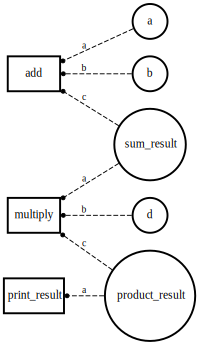

In [22]:
plot_bigraph(instance, rankdir='RL')

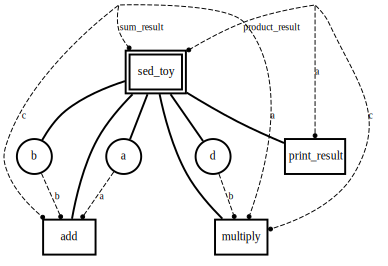

In [23]:
# Example function calls with input and output arguments
sed_toy = {
    'sed_toy': {
        **instance,
        '_ports': {
            'sum_result': 'Any',
            'product_result': 'Any',
        },
    }
}
plot_bigraph(sed_toy, rankdir='TB')

{ 'instance': { 'COPASI': { '_type': 'sed:simulator',
                            '_version': '0.1.1',
                            'wires': { 'a': 'sum_result',
                                       'b': 'd',
                                       'c': 'product_result'}},
                'a': 2,
                'add': { '_type': 'math:add',
                         'wires': {'a': 'a', 'b': 'b', 'c': 'sum_result'}},
                'b': 3,
                'd': 5,
                'print_result': { '_depends_on': [],
                                  '_type': 'math:print_result',
                                  'wires': {'a': 'product_result'}}},
  'ontologies': ['math', 'sed']}


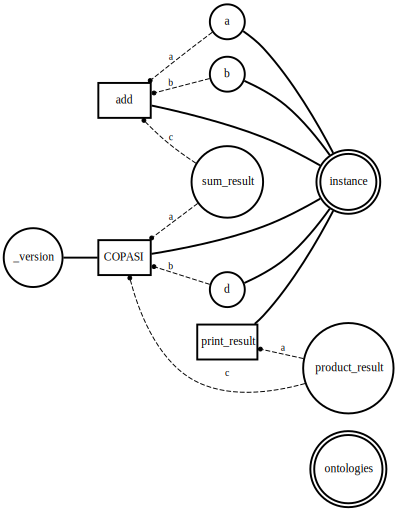

In [24]:
sed = {
    'ontologies': ['math', 'sed'],
    'instance': {
        'add': {
            '_type': 'math:add',
            'wires': {
                'a': 'a', 
                'b': 'b', 
                'c': 'sum_result',
            }
        },
        'COPASI': {
            '_type': 'sed:simulator',
            '_version': '0.1.1',
            'wires': {
                'a': 'sum_result', 
                'b': 'd',
                'c': 'product_result',
            }
        },
        'print_result': {
            '_type': 'math:print_result',
            'wires': {
                'a': 'product_result', 
            },
            '_depends_on': [],
        },
        'a': 2,
        'b': 3,
        'd': 5,
    }
}
print(pf(sed))
plot_bigraph(sed, rankdir='RL')